In [16]:
import os
import sys
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML, display
from ipywidgets import *

from fedless.benchmark.fedkeeper import create_mnist_cnn
from fedless.benchmark.leaf import create_femnist_cnn
from fedless.serialization import NpzWeightsSerializer

from plot_utils import process_flower_logs
from plot_utils import calc_gcloud_function_cost

%matplotlib inline

In [60]:
SNS_DEFAULT_PALETTE = sns.color_palette("mako")#, as_cmap=True)
sns.set(#font="Helvetica", #"Franklin Gothic Book",
        rc={
 #‘axes.axisbelow’: False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": True,
 #‘axes.labelcolor’: ‘dimgrey’,
 "axes.spines.right": False,
 "axes.spines.top": False,
"figure.autolayout": True,
 #‘figure.facecolor’: ‘white’,
 #‘lines.solid_capstyle’: ‘round’,
 #‘patch.edgecolor’: ‘w’,
 #‘patch.force_edgecolor’: True,
 #‘text.color’: ‘dimgrey’,
 #‘xtick.bottom’: False,
 #‘xtick.color’: ‘dimgrey’,
 #‘xtick.direction’: ‘out’,
 #‘xtick.top’: False,
 #‘ytick.color’: ‘dimgrey’,
 #‘ytick.direction’: ‘out’,
 #‘ytick.left’: False,
 #‘ytick.right’: False})
        })

sns.set_context("paper", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18, 
                               "xtick.labelsize": 13,
                               "ytick.labelsize": 13,})

In [36]:
FLOWER_LOGS_FOLDER = Path("/Users/andreas/workspace/thesis-code/out/flower-logs")

In [25]:
flower_df = process_flower_logs(FLOWER_LOGS_FOLDER)

In [26]:
fedless_dfs = []
fedless_client_dfs = []
for folder in Path("/Users/andreas/workspace/thesis-code/out/").glob("fedless-*-flower-*"):
    dataset = folder.name.split("-")[1]
    clients_in_round = int(folder.name.split("-")[3])
    for timing_file in folder.glob("timing*.csv"):
        seed = timing_file.name.split("_")[1].split(".")[0]
        #config_file = timing_file.parent / f"config_{seed}.json"
        #hyperparams = {}
        #if config_file.exists():
        #    config = json.loads(config_file.read_text())
        #    hyperparams = config["clients"]["hyperparams"]        
#        
        df = pd.read_csv(timing_file)
        index = pd.MultiIndex.from_tuples(
        [(
            dataset,
            clients_in_round,
            #clients_total,
            #local_epochs,
            #batch_size,
            seed
        )] * len(df),
        names=[
            "dataset",
            "clients_in_round",
            #"clients_total",
            #"local_epochs",
            #"batch_size",
            "seed"
        ]
        )
        df = pd.DataFrame(df.values, index=index, columns=df.columns)
        df.rename(columns = {
            'round_id':'round', 
            'global_test_accuracy': 'accuracy',
            'global_test_loss': 'loss',
            'round_seconds': 'time',
            'clients_finished_seconds': 'time_clients_fit'
        }, inplace = True)
        new_dtypes = {
            "session_id": str, 
            "round": int, 
            "accuracy": float,
            "loss": float,
            "time": float,
            "time_clients_fit": float,
            "num_clients_round": int,
            #"time_since_start": float, 
            #"time_agg_eval": float
        }
        if not df.empty:
            df = df.astype(new_dtypes)
        fedless_dfs.append(df)
        
        
    for client_file in folder.glob("clients*.csv"):
        seed = client_file.name.split("_")[1].split(".")[0]
        df = pd.read_csv(client_file)
        index = pd.MultiIndex.from_tuples(
        [(
            dataset,
            clients_in_round,
            seed
        )] * len(df),
        names=[
            "dataset",
            "clients_in_round",
            "seed"
        ]
        )
        df = pd.DataFrame(df.values, index=index, columns=df.columns)
        #df.rename(columns = {
        #    'round_id':'round', 
        #    'global_test_accuracy': 'accuracy',
        #    'global_test_loss': 'loss',
        #    'round_seconds': 'time',
        #    'clients_finished_seconds': 'time_clients_fit'
        #}, inplace = True)
        new_dtypes = {
            "seconds": float,
            "round": int
        }
        if not df.empty:
            df = df.astype(new_dtypes)
        fedless_client_dfs.append(df)
    
fedless_df = pd.concat(fedless_dfs)
fedless_client_df = pd.concat(fedless_client_dfs)

## MNIST

#### Accuracy over Rounds

<ipython-input-61-a7f7ad5d6221>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("mnist", clients_in_round)]
<ipython-input-61-a7f7ad5d6221>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("mnist", clients_in_round)]
<ipython-input-61-a7f7ad5d6221>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("mnist", clients_in_round)]
<ipython-input-61-a7f7ad5d6221>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("mnist", clients_in_round)]
<ipython-input-61-a7f7ad5d6221>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("mnist", clients_in_round)]


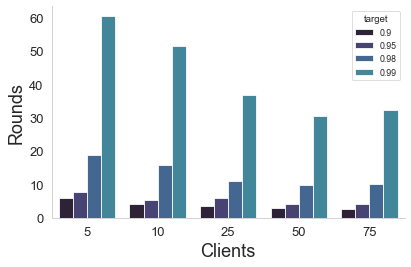

In [61]:
vals = []
target = 0.90
for clients_in_round in [5, 10, 25, 50, 75]:
    df_ = fedless_df.loc[("mnist", clients_in_round)]
    for target in [0.9, 0.95, 0.98, 0.99]:
        mean_round_until_target_fedless= df_[df_["accuracy"] >= target].groupby("seed").min("round")["round"].mean() 
        vals.append((target, mean_round_until_target_fedless, clients_in_round))
df_ = pd.DataFrame(vals, columns=["target", "rounds", "n_clients"])
fig, ax = plt.subplots()

sns.barplot(x="n_clients", y="rounds", data=df_, hue="target", palette=SNS_DEFAULT_PALETTE, ax=ax)
ax.set_xlabel("Clients")
ax.set_ylabel("Rounds")
fig.savefig("fedless-mnist-rounds-varying-clients.pdf")

In [7]:
vals = []

for target in [0.9, 0.95, 0.98, 0.99]:
    df_ = flower_df.loc[("mnist", 75, 100, 5)]
    mean_round_until_target_flower = df_[df_["accuracy"] >= target].groupby("seed").min("round")["round"].mean()
    vals.append((target, mean_round_until_target_flower, "flower"))
    df_ = fedless_df.loc[("mnist", 75)]
    mean_round_until_target_fedless= df_[df_["accuracy"] >= target].groupby("seed").min("round")["round"].mean() 
    vals.append((target, mean_round_until_target_fedless, "fedless"))
    

df_ = pd.DataFrame(vals, columns=["target", "rounds", "method"])
sns.barplot(x="target", y="rounds", hue="method", data=df_)
df_.pivot(columns="method", values="rounds", index="target")

<ipython-input-7-ce6782200e1f>:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("mnist", 75)]
<ipython-input-7-ce6782200e1f>:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("mnist", 75)]
<ipython-input-7-ce6782200e1f>:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("mnist", 75)]
<ipython-input-7-ce6782200e1f>:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("mnist", 75)]


method,fedless,flower
target,,
0.90,2.666667,4.333333
0.95,4.000000,6.000000
0.98,10.000000,12.666667
0.99,32.333333,37.333333


#### Round Durations

In [8]:
vals = []
detail_vals = []

flwr_df_ = flower_df.loc[("mnist", 75, 100, 5)]
flwr_cold_df_ = flwr_df_[flwr_df_["round"] == 1]
flwr_warm_df_ = flwr_df_[flwr_df_["round"] > 1]
for t in flwr_cold_df_["time"]:
    vals.append(("flower", "cold", "round", t))
for t in flwr_warm_df_["time"]:
    vals.append(("flower", "warm", "round", t))
for t in flwr_warm_df_["time_agg_eval"]:
    vals.append(("flower", "warm", "agg_eval", t))
#for t in flwr_warm_df_["time_clients_fit"]:
#    vals.append(("flower", "warm", "time_clients_fit", t))


fls_df_ = fedless_df.loc[("mnist", 75)]
fls_cold_df_ = fls_df_[fls_df_["round"] == 1]
fls_warm_df_ = fls_df_[fls_df_["round"] > 1]
for t in fls_cold_df_["time"]:
    vals.append(("fedless", "cold", "round", t))
for t in fls_warm_df_["time"]:
    vals.append(("fedless", "warm", "round", t))
for t in fls_warm_df_["aggregator_seconds"]:
    vals.append(("fedless", "warm", "agg_eval", t))
#for t in fls_warm_df_["time_clients_fit"]:
#    vals.append(("fedless", "warm", "time_clients_fit", t))
    


df_ = pd.DataFrame(vals, columns=["method", "state", "task", "duration"])
    
fig, axarr = plt.subplots(ncols=4, figsize=(16, 4))

# Warm Durations
df_warm_ = df_[(df_["state"] == "warm") & (df_["task"] == "round")]
sns.barplot(x="method", y="duration", data=df_warm_, ax=axarr[0])
axarr[0].set_title("Flower vs Fedless Round Durations")

# Cold vs Warm Fedless
df_fedless_ = df_[(df_["method"] == "fedless") & (df_["task"] == "round")]
sns.boxplot(x="state", y="duration", data=df_fedless_, ax=axarr[1])
axarr[1].set_title("Fedless Round Durations")
#df_rounds_ = df_[(df_["task"] == "round")]
#sns.boxplot(x="method", y="duration", data=df_rounds_, ax=axarr[1], hue="state")
#axarr[1].set_title("Hot vs Warm Invocation")

# Timing Breakdown
sns.barplot(x="method", y="duration", data=df_, ax=axarr[2], hue="task")
axarr[2].set_title("Round vs Aggregation Time")

#df_warm_.groupby(["method", "state"]).mean("duration")
print(f"Warm duration differnce mean")
print(df_warm_.groupby("method").mean())

sns.violinplot(y="seconds", data=fedless_client_df.loc[("mnist", 75)], ax=axarr[3])
axarr[3].set_title("Fedless Client Durations")

print(f"Fedless Timings")
print(fedless_client_df.loc[("mnist", 75)].groupby("eval").median())

<ipython-input-8-d09e3bfd6871>:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fls_df_ = fedless_df.loc[("mnist", 75)]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Warm duration differnce mean
          duration
method            
fedless  19.520810
flower   12.018501
Fedless Timings
        seconds  round
eval                  
False  7.062003     16


<ipython-input-8-d09e3bfd6871>:56: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.violinplot(y="seconds", data=fedless_client_df.loc[("mnist", 75)], ax=axarr[3])
<ipython-input-8-d09e3bfd6871>:60: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(fedless_client_df.loc[("mnist", 75)].groupby("eval").median())


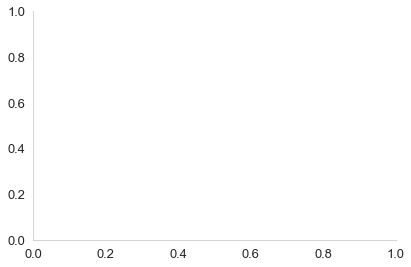

interactive(children=(IntSlider(value=100, description='clients_per_round', max=200, min=5, step=5), IntSlider…

<function __main__.f(clients_per_round, clients_total)>

In [62]:
model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_mnist_cnn().get_weights())) / 10**6
flwr_df_ = flower_df.loc[("mnist", 75, 100, 5)]
instance_runtime_orig = flwr_df_.groupby("seed").max("time_since_start").median()["time_since_start"]


x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#line, = ax.plot(x, np.sin(x))

def f(clients_per_round, clients_total):
    #selem = disk(int(Median_Size))
    #with warnings.catch_warnings():
    #    warnings.simplefilter("ignore")
    #    img_median = rank.median(img_gray, selem=selem) 
    
    n_clients_per_round = clients_per_round
    n_rounds = 5000 / n_clients_per_round
    n_instances = clients_total
    n_invocations = n_rounds * n_clients_per_round 
    instance_runtime = instance_runtime_orig / ((n_clients_per_round) / 75) # 3600 / n_clients_per_round


    #ax_neu.imshow(img_median, cmap="gray")
    iaas = []
    faas = []
    
    for n_invocations in range(1, 10000, 100) :
        # 8192MB 	4.8 GHz 	$0.000006800
        memory, cpu_ghz, _ = 2048, 2.4, 2.9e-06
        #memory, cpu_ghz, _ = 8192, 4.8, 2.9e-06
        faas_cost = calc_gcloud_function_cost(
                                memory=memory, 
                                cpu_ghz=cpu_ghz,
                                invocations=n_invocations,
                                function_runtime_seconds=7.062003,
                                function_egress_mb=model_size,
                                substract_free_tier=False)

        # Gcloud Instance
        # e2-standard-2 	2 	8GB 	$0.086334  per hour
        # n2-standard-2 	2 	8GB 	$0.097118
        NETWORKING_UNIT_PRICE = 0.12

        egress_cost = (n_invocations * model_size / 1024) * NETWORKING_UNIT_PRICE
        instance_cost = n_instances * (instance_runtime / 3600) * 0.097118
        iaas_cost = instance_cost + egress_cost
        faas.append(faas_cost)
        iaas.append(iaas_cost)
        #print(instance_cost, egress_cost)
        #print(f"IaaS Cost: {iaas_cost}")
        #print(f"FaaS Cost: {faas_cost}")
    faas = np.array(faas)
    iaas = np.array(iaas)
    break_even_point = np.abs(faas - iaas).argmin() * 100
    print(f"break_even_point: {break_even_point}, {break_even_point / n_clients_per_round} for {n_clients_per_round} clients per round")
    #[l.remove() for l in ax.lines]
    #if ax.get_legend():
    #    ax.get_legend().remove()
    ax.clear()
    ax.vlines(break_even_point, linestyles='dashed', color="red", ymin=np.min(faas), ymax=np.max(faas))
    ax.plot(list(range(1, 10000, 100)), faas, label="FaaS")
    ax.plot(list(range(1, 10000, 100)), iaas, label="IaaS")
    ax.legend()
    
    fig.canvas.draw()
#    display(fig)
    
interact(f, clients_per_round=widgets.IntSlider(min=5,max=200,step=5,value=100), clients_total=widgets.IntSlider(min=20,max=1000,step=5,value=100))

## FEMNIST

#### Accuracy over Rounds

<ipython-input-63-6051785fd4c2>:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("femnist", 75)]
<ipython-input-63-6051785fd4c2>:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("femnist", 75)]
<ipython-input-63-6051785fd4c2>:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("femnist", 75)]
<ipython-input-63-6051785fd4c2>:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("femnist", 75)]


<AxesSubplot:xlabel='round', ylabel='accuracy'>

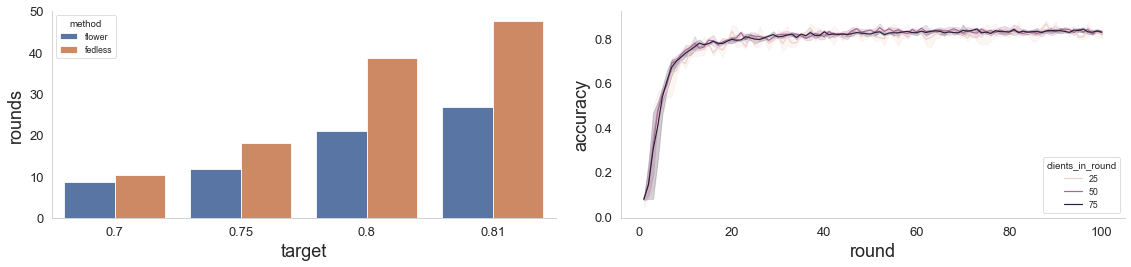

In [63]:
vals = []

for target in [0.7, 0.75, 0.8, 0.81]:
    df_ = flower_df.loc[("femnist", 75, 100, 5)]
    mean_round_until_target_flower = df_[df_["accuracy"] >= target].groupby("seed").min("round")["round"].mean()
    vals.append((target, mean_round_until_target_flower, "flower"))
    df_ = fedless_df.loc[("femnist", 75)]
    mean_round_until_target_fedless= df_[df_["accuracy"] >= target].groupby("seed").min("round")["round"].mean() 
    vals.append((target, mean_round_until_target_fedless, "fedless"))
    
fig, axarr = plt.subplots(ncols=2, figsize=(16, 4))
df_ = pd.DataFrame(vals, columns=["target", "rounds", "method"])
sns.barplot(x="target", y="rounds", hue="method", data=df_, ax=axarr[0])
df_.pivot(columns="method", values="rounds", index="target")

df_ = flower_df.loc[("femnist", slice(1,100), 100, 5)]
sns.lineplot(x="round", y="accuracy",  data=df_, ax=axarr[1], hue="clients_in_round")

In [11]:
vals = []
for clients_in_round in [25, 50, 75]:
    df_ = fedless_df.loc[("femnist", clients_in_round)]
    for target in [0.7, 0.8, 0.81, 0.82, 0.83]:
        mean_round_until_target_fedless= df_[df_["accuracy"] >= target].groupby("seed").min("round")["round"].mean() 
        vals.append((target, mean_round_until_target_fedless, clients_in_round))
df_ = pd.DataFrame(vals, columns=["target", "rounds", "n_clients"])
sns.barplot(x="n_clients", y="rounds", data=df_, hue="target", palette=SNS_DEFAULT_PALETTE)

<ipython-input-11-7b4f1ac793d1>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("femnist", clients_in_round)]
<ipython-input-11-7b4f1ac793d1>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("femnist", clients_in_round)]
<ipython-input-11-7b4f1ac793d1>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_df.loc[("femnist", clients_in_round)]


<AxesSubplot:xlabel='n_clients', ylabel='rounds'>

#### Round Durations

In [12]:
vals = []
detail_vals = []

flwr_df_ = flower_df.loc[("femnist", 75, 100, 5)]
flwr_cold_df_ = flwr_df_[flwr_df_["round"] == 1]
flwr_warm_df_ = flwr_df_[flwr_df_["round"] > 1]
for t in flwr_cold_df_["time"]:
    vals.append(("flower", "cold", "round", t))
for t in flwr_warm_df_["time"]:
    vals.append(("flower", "warm", "round", t))
for t in flwr_warm_df_["time_agg_eval"]:
    vals.append(("flower", "warm", "agg_eval", t))
for t in flwr_warm_df_["time_clients_fit"]:
    vals.append(("flower", "warm", "time_clients_fit", t))


fls_df_ = fedless_df.loc[("femnist", 75)]
fls_cold_df_ = fls_df_[fls_df_["round"] == 1]
fls_warm_df_ = fls_df_[fls_df_["round"] > 1]
for t in fls_cold_df_["time"]:
    vals.append(("fedless", "cold", "round", t))
for t in fls_warm_df_["time"]:
    vals.append(("fedless", "warm", "round", t))
for t in fls_warm_df_["aggregator_seconds"]:
    vals.append(("fedless", "warm", "agg_eval", t))
for t in fls_warm_df_["time_clients_fit"]:
    vals.append(("fedless", "warm", "time_clients_fit", t))
    

df_ = pd.DataFrame(vals, columns=["method", "state", "task", "duration"])
    
fig, axarr = plt.subplots(ncols=5, figsize=(25, 5))

# Warm Durations
df_warm_ = df_[(df_["state"] == "warm") & (df_["task"] == "round")]
sns.barplot(x="method", y="duration", data=df_warm_, ax=axarr[0])
#sns.violinplot(x="method", y="duration", data=df_warm_, ax=axarr[0])
#sns.boxplot(x="method", y="duration", data=df_warm_, ax=axarr[0])
axarr[0].set_ylim(0, 80)
axarr[0].set_title("Flower vs Fedless Round Durations")

df_warm_ = df_[(df_["state"] == "warm") & (df_["task"] == "time_clients_fit")]
sns.barplot(x="method", y="duration", data=df_warm_, ax=axarr[1])
axarr[1].set_title("Flower vs Fedless Client Wait Time Durations")

# Cold vs Warm Fedless
df_fedless_ = df_[(df_["method"] == "fedless") & (df_["task"] == "round")]
sns.boxplot(x="state", y="duration", data=df_fedless_, ax=axarr[2])
axarr[2].set_title("Fedless Round Durations")

# Timing Breakdown
sns.barplot(x="method", y="duration", data=df_, ax=axarr[3], hue="task")
axarr[3].set_title("Round vs Aggregation Time")

sns.boxplot(x="eval", y="seconds", data=fedless_client_df.loc[("femnist", 75)], ax=axarr[4])
axarr[4].set_title("Fedless Client Durations")

#df_warm_.groupby(["method", "state"]).mean("duration")
print(f"Warm duration differnce mean")
df_warm_ = df_[(df_["state"] == "warm") & (df_["task"] == "round")]
table_df_ = df_warm_.groupby("method").mean()
table_df_["pct-change"] = table_df_.pct_change()
print(table_df_)

print(f"Fedless Timings")
print(fedless_client_df.loc[("femnist", 75)].groupby("eval").median())

<ipython-input-12-169392d5fe96>:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fls_df_ = fedless_df.loc[("femnist", 75)]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Warm duration differnce mean
          duration  pct-change
method                        
fedless  47.931538         NaN
flower   27.351825   -0.429356
Fedless Timings
         seconds  round
eval                   
False  14.870215     46
True    2.502864     47


<ipython-input-12-169392d5fe96>:55: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.boxplot(x="eval", y="seconds", data=fedless_client_df.loc[("femnist", 75)], ax=axarr[4])
<ipython-input-12-169392d5fe96>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(fedless_client_df.loc[("femnist", 75)].groupby("eval").median())


In [13]:
n_rounds = 30
n_clients_per_round = 75
n_instances = 100
n_invocations = n_rounds * n_clients_per_round 

model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_femnist_cnn().get_weights())) / 10**6
flwr_df_ = flower_df.loc[("femnist", 75, 100, 5)]
instance_runtime = flwr_df_.groupby("seed").max("time_since_start").median()["time_since_start"]

iaas = []
faas = []

for n_invocations in range(1, 100000) :
    # 8192MB 	4.8 GHz 	$0.000006800
    memory, cpu_ghz, _ = 2048, 2.4, 2.9e-06
    #memory, cpu_ghz, _ = 8192, 4.8, 2.9e-06
    faas_cost = calc_gcloud_function_cost(
                            memory=memory, 
                            cpu_ghz=cpu_ghz,
                            invocations=n_invocations,
                            function_runtime_seconds=17.373079,
                            function_egress_mb=model_size,
                            substract_free_tier=False)
    
    # Gcloud Instance
    # e2-standard-2 	2 	8GB 	$0.086334  per hour
    NETWORKING_UNIT_PRICE = 0.12
    
    egress_cost = (n_invocations * model_size / 1024) * NETWORKING_UNIT_PRICE
    instance_cost = n_instances * (instance_runtime / 3600) * 0.086334
    iaas_cost = instance_cost + egress_cost
    faas.append(faas_cost)
    iaas.append(iaas_cost)
    #print(instance_cost, egress_cost)
    #print(f"IaaS Cost: {iaas_cost}")
    #print(f"FaaS Cost: {faas_cost}")
faas = np.array(faas)
iaas = np.array(iaas)
break_even_point = np.abs(faas - iaas).argmin()
print(f"break_even_point: {break_even_point}, {break_even_point / 75} for {75} clients per round")
plt.vlines(break_even_point, linestyles='dashed', color="red", ymin=np.min(faas), ymax=np.max(faas))
plt.plot(list(range(1, 100000)), faas, label="FaaS")
plt.plot(list(range(1, 100000)), iaas, label="IaaS")
plt.legend()

break_even_point: 13116, 174.88 for 75 clients per round


## SHAKESPEARE

In [14]:
vals = []

for target in [0.3, 0.4, 0.45]:
    df_ = flower_df.loc[("shakespeare", 25, 100, 1)]
    mean_round_until_target_flower = df_[df_["accuracy"] >= target].groupby("seed").min("round")["round"].mean()
    vals.append((target, mean_round_until_target_flower, "flower"))
    df_ = fedless_df.loc["shakespeare"]
    mean_round_until_target_fedless= df_[df_["accuracy"] >= target].groupby("seed").min("round")["round"].mean() 
    vals.append((target, mean_round_until_target_fedless, "fedless"))
    

df_ = pd.DataFrame(vals, columns=["target", "rounds", "method"])
sns.barplot(x="target", y="rounds", hue="method", data=df_)
df_.pivot(columns="method", values="rounds", index="target")

KeyError: ('shakespeare', 25, 100, 1)

In [ ]:
vals = []
detail_vals = []

flwr_df_ = flower_df.loc[("shakespeare", 25, 100, 1)]
flwr_cold_df_ = flwr_df_[flwr_df_["round"] == 1]
flwr_warm_df_ = flwr_df_[flwr_df_["round"] > 1]
for t in flwr_cold_df_["time"]:
    vals.append(("flower", "cold", "round", t))
for t in flwr_warm_df_["time"]:
    vals.append(("flower", "warm", "round", t))
for t in flwr_warm_df_["time_agg_eval"]:
    vals.append(("flower", "warm", "agg_eval", t))
for t in flwr_warm_df_["time_clients_fit"]:
    vals.append(("flower", "warm", "time_clients_fit", t))


fls_df_ = fedless_df.loc["shakespeare"]
fls_cold_df_ = fls_df_[fls_df_["round"] == 1]
fls_warm_df_ = fls_df_[fls_df_["round"] > 1]
for t in fls_cold_df_["time"]:
    vals.append(("fedless", "cold", "round", t))
for t in fls_warm_df_["time"]:
    vals.append(("fedless", "warm", "round", t))
for t in fls_warm_df_["aggregator_seconds"]:
    vals.append(("fedless", "warm", "agg_eval", t))
for t in fls_warm_df_["time_clients_fit"]:
    vals.append(("fedless", "warm", "time_clients_fit", t))
    

df_ = pd.DataFrame(vals, columns=["method", "state", "task", "duration"])
    
fig, axarr = plt.subplots(ncols=5, figsize=(25, 5))

# Warm Durations
df_warm_ = df_[(df_["state"] == "warm") & (df_["task"] == "round")]
sns.barplot(x="method", y="duration", data=df_warm_, ax=axarr[0])
#sns.violinplot(x="method", y="duration", data=df_warm_, ax=axarr[0])
#sns.boxplot(x="method", y="duration", data=df_warm_, ax=axarr[0])
#axarr[0].set_ylim(0, 80)
axarr[0].set_title("Flower vs Fedless Round Durations")

df_warm_ = df_[(df_["state"] == "warm") & (df_["task"] == "time_clients_fit")]
sns.barplot(x="method", y="duration", data=df_warm_, ax=axarr[1])
axarr[1].set_title("Flower vs Fedless Client Wait Time Durations")

# Cold vs Warm Fedless
df_fedless_ = df_[(df_["method"] == "fedless") & (df_["task"] == "round")]
sns.boxplot(x="state", y="duration", data=df_fedless_, ax=axarr[2])
axarr[2].set_title("Fedless Round Durations")

# Timing Breakdown
sns.barplot(x="method", y="duration", data=df_, ax=axarr[3], hue="task")
axarr[3].set_title("Round vs Aggregation Time")


sns.boxplot(x="eval", y="seconds", data=fedless_client_df.loc["shakespeare"], ax=axarr[4])
axarr[4].set_title("Fedless Client Durations")

fig.savefig("/Users/andreas/Desktop/shakespeare.pdf")

#sns.lineplot(x="round", y="seconds", data=fedless_client_df.loc["shakespeare"], ax=axarr[4])

#df_warm_.groupby(["method", "state"]).mean("duration")
print(f"Warm duration differnce mean")
df_warm_ = df_[(df_["state"] == "warm") & (df_["task"] == "round")]
table_df_ = df_warm_.groupby("method").mean()
table_df_["pct-change"] = table_df_.pct_change()
print(table_df_)

In [ ]:
sns.barplot(x="client_id", y="seconds", data=fedless_client_df.loc["shakespeare"])

In [ ]:
flwr_df_ = flower_df.loc[("mnist", 75, 100, 5)]
flwr_cold_df_ = flwr_df_[flwr_df_["round"] == 1]
flwr_warm_df_ = flwr_df_[flwr_df_["round"] > 1]
flwr_cold_df_